In [1]:
import pandas as pd
import numpy as np
import load_data
import picklemanager as pickm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

ds = load_data.drifter_data_hourly()


In [2]:
def plot_global_density(latitude, longitude, lat_box_size=5, lon_box_size=5, latlon_box_size=None, scatter=False, title=None, ax=None, crs=ccrs.PlateCarree()):
    if ax is None:
        fig = plt.figure(figsize=(14, 9), dpi=300)
        ax = plt.axes(projection=crs)

        ax.set_global()
        ax.set_ylim([-85, 85])
        ax.coastlines()

        gl = ax.gridlines(draw_labels=True)
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.top_labels = gl.right_labels = False

    df = pd.DataFrame({'lat': latitude, 'lon': longitude})

    if latlon_box_size is not None:
        lat_box_size = latlon_box_size
        lon_box_size = latlon_box_size

    # Calculate the box indices for each coordinate
    df['lat_box'] = ((df['lat'] + 90) // lat_box_size)
    df['lon_box'] = ((df['lon'] + 180) // lon_box_size)

    # reduce lon_box to 0-max_lat_box_id and lat_box to 0-max_lon_box_id for drifters exactly on 90N or 180E
    df['lon_box'] = df['lon_box'] % int(360/lon_box_size)
    df['lat_box'] = df['lat_box'] % int(180/lat_box_size)

    # Group the coordinates by box indices and count the number of coordinates in each box
    grouped = df.groupby(['lat_box', 'lon_box']).size().reset_index(name='count')

    # Create an empty grid to store the density values
    density_grid = np.zeros((int(180/lat_box_size), int(360/lon_box_size)))

    # Fill the density grid with the count values
    for _, row in grouped.iterrows():
        i_lat_box = int(row['lat_box'])
        i_lon_box = int(row['lon_box'])
        count = row['count']
        density_grid[i_lat_box, i_lon_box] = count

    X, Y = np.meshgrid(np.arange(-180, 180, lon_box_size), np.arange(-90, 90, lat_box_size))

    im = ax.pcolormesh(X, Y, density_grid, shading='nearest', cmap='hot_r', norm=colors.LogNorm(), transform=ccrs.PlateCarree())
    if scatter:
        ax.scatter(longitude, latitude, s=0.1, color='b', alpha=0.5, transform=crs)
    # Add a colorbar
    cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 10, 100, 1000, 10000], format=ticker.ScalarFormatter(), shrink=0.6)
    cbar.set_label('Density')

    if title is not None:
        ax.set_title(title)

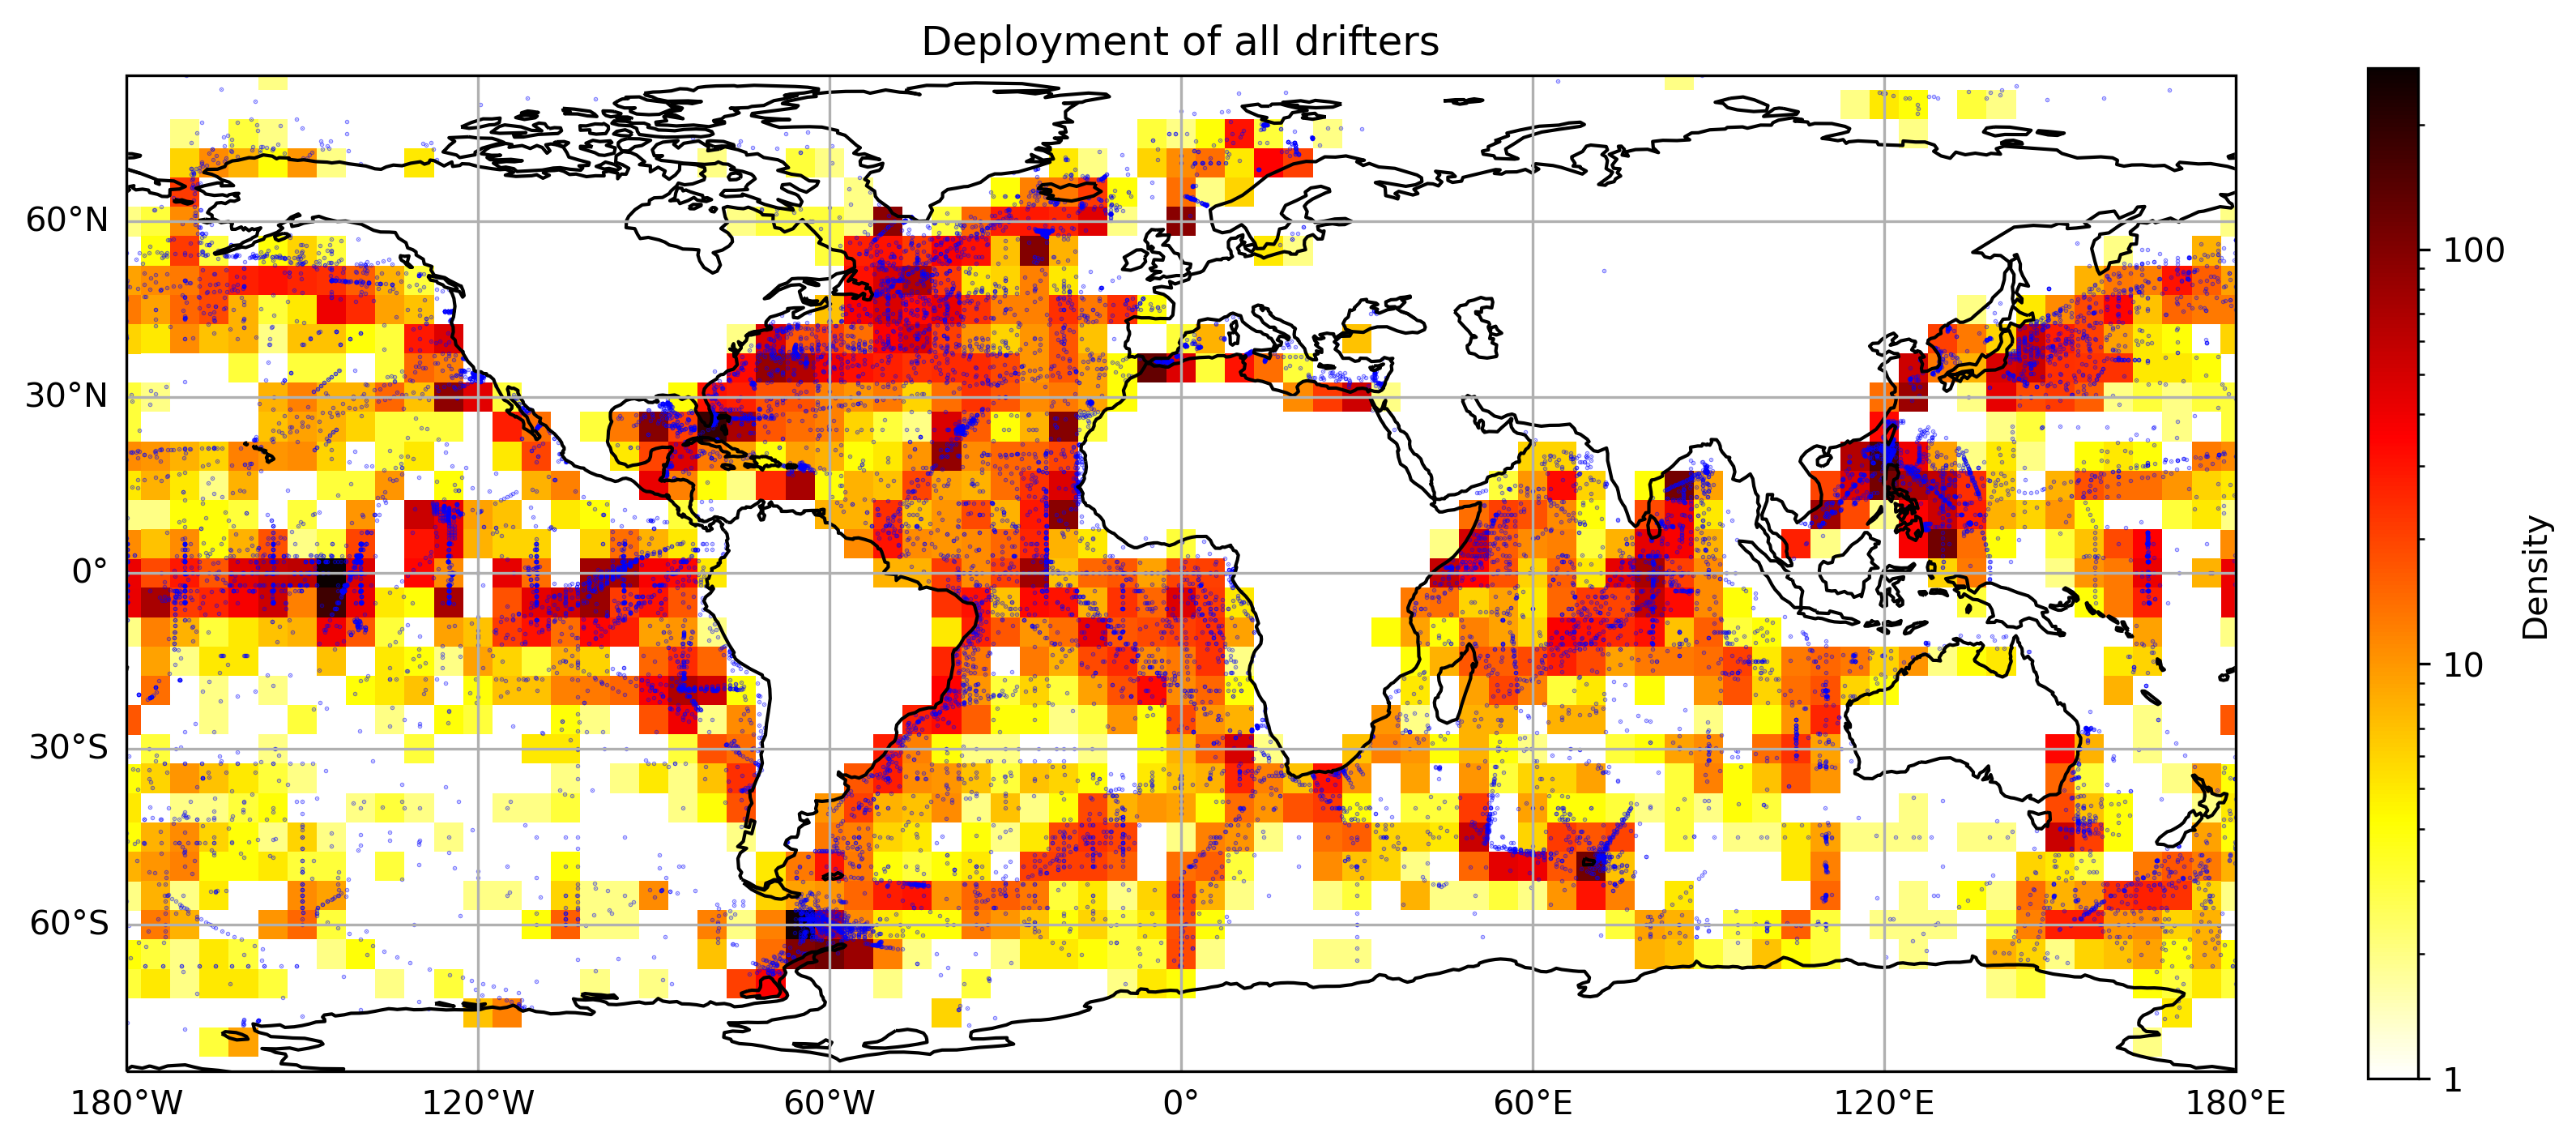

In [3]:
plot_global_density(ds.deploy_lat.values, ds.deploy_lon.values, title='Deployment of all drifters', scatter=True)
plt.show()

In [ ]:
percentage = 100
random_set = 1
gps_only = True
undrogued_only = False
threshold_aprox_distance_km = None
start_date = None
end_date = None

name = f'subset_{percentage}{(f"_{random_set}" if percentage < 100 else "")}'\
       f'{("_" + str(start_date) if start_date is not None else "")}' \
       f'{("_" + str(end_date) if end_date is not None else "")}' \
       f'{("_gps" if gps_only else "")}' \
       f'{("_undrogued" if undrogued_only else "")}' \
       f'{("_" + str(threshold_aprox_distance_km) + "km" if threshold_aprox_distance_km is not None else "")}'

ds_gps = load_data.load_subset(percentage, gps_only, undrogued_only, threshold_aprox_distance_km, start_date, end_date, ds=ds)


plot_global_density(ds_gps.latitude.values, ds_gps.longitude.values, title='GPS drifters', crs=ccrs.PlateCarree())
plt.show()

In [ ]:
percentage = 100
random_set = 1
gps_only = True
undrogued_only = True
threshold_aprox_distance_km = 12
start_date = None
end_date = None

name = f'subset_{percentage}{(f"_{random_set}" if percentage < 100 else "")}'f'{("_" + str(start_date) if start_date is not None else "")}'f'{("_" + str(end_date) if end_date is not None else "")}'f'{("_gps" if gps_only else "")}'f'{("_undrogued" if undrogued_only else "")}'f'{("_" + str(threshold_aprox_distance_km) + "km" if threshold_aprox_distance_km is not None else "")}'

ds_gps_undrogued = pickm.pickle_wrapper('ds_gdp_' + name, load_data.load_subset, percentage, gps_only, undrogued_only,
                                        threshold_aprox_distance_km, start_date, end_date)

plot_global_density(ds_gps_undrogued.latitude, ds_gps_undrogued.longitude, title='undrogued GPS drifters')
